# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.962720,True,7.407084
1,0.249559,True,5.491634
2,-0.659273,False,-1.193523
3,1.772145,True,8.664534
4,-0.092658,False,-0.467651
...,...,...,...
995,-0.425301,False,0.387535
996,-0.891500,True,3.750981
997,-1.384918,False,-3.066749
998,-0.261407,True,3.826111


<AxesSubplot:xlabel='v0'>

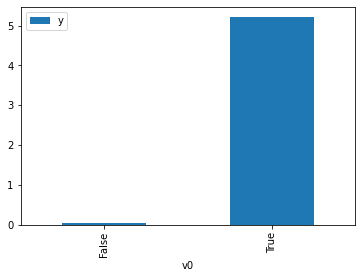

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

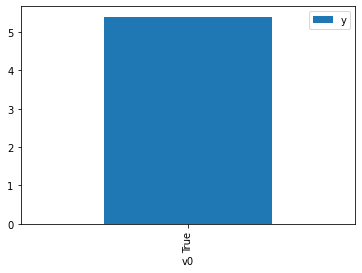

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.243913,False,-2.536105,0.800898,1.248598
1,0.972700,False,1.131601,0.283591,3.526203
2,-0.025845,False,0.785652,0.529413,1.888886
3,1.532202,False,3.324288,0.180647,5.535661
4,-0.095901,False,0.475500,0.547622,1.826077
...,...,...,...,...,...
995,0.493804,False,1.441334,0.395135,2.530783
996,0.344784,False,1.007399,0.432931,2.309835
997,-0.861849,False,-3.199634,0.729536,1.370735
998,0.926856,False,3.266609,0.293434,3.407920


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.677622,True,3.282862,0.310119,3.224566
1,1.421611,True,9.508700,0.801594,1.247514
2,0.886737,True,7.012762,0.697790,1.433095
3,-0.158396,True,6.764459,0.436239,2.292320
4,1.378892,True,9.509055,0.794392,1.258825
...,...,...,...,...,...
995,0.221864,True,5.617360,0.535272,1.868209
996,0.219137,True,6.838306,0.534562,1.870689
997,0.911654,True,8.169008,0.703258,1.421953
998,-0.834733,True,5.204245,0.276097,3.621914


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.182e+04
Date:                Tue, 02 Aug 2022   Prob (F-statistic):                        0.00
Time:                        07:51:14   Log-Likelihood:                         -1459.2
No. Observations:                1000   AIC:                                      2922.
Df Residuals:                     998   BIC:                                      2932.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4085      0.035     69.523      0.000       2.341       2.476
x2             5.0205      0.050    100.124      0.000       4.922       5.119
==============================================================================
Omnibus:                        1.671   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.532
Skew:                           0.074   Prob(JB):                        0.465
Kurtosis:                       3.122   Cond. No.                         1.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""